Este conjunto de datos contiene observaciones de pago de clientes de un banco taiwanés en el año 2005, incluyendo variables demográficas (genero, estado civil, edad, nivel educativo), variables categoricas que describen el estado de pago de un mes dado para el periodo Abril-Septiembre y variables numéricas que describen tanto la factura a pagar en cada uno de esos meses como el pago efectivo realizado por la persona en dicho mes. También se incluye la linea de crédito de la persona y un estado binario para el mes de octubre que indica si la persona pago su resumen en ese mes. A continuación describimos con más detalle las variables:
- `LIMIT BAL`: límite de crédito otorgado (dolares taiwaneses [NT dolar])
- `SEX`: género  (1 = masculino; 2 = femenino)
- `EDUCATION`: nivel educativo (1 = posgrado; 2 = universidad; 3 = escuela secundaria; 4 = otros)
- `MARRIAGE`: estado civil (1 = casado; 2 = soltero; 3 = otros)
- `AGE`: edad
- `PAY_0` a `PAY_6`: estado de pago de los últimos 6 meses (septiembre-abril)
  - -2 = Pago el total del balance, y no tuvo mas consumos en el mes *
  - -1 = usó crédito y pago el total a tiempo
  -  0 = usó crédito pero hizo un pago minimo (no entró en mora) *
  - Escala de n en [1;9+]: atrasado n meses
- `BILL_AMT0` a `BILL_AMT6`: monto facturado en los últimos 6 meses
- `PAY_AMT0` a `PAY_AMT6`: monto pagado en los últimos 6 meses
- `default payment next month`: estado de default en octubre (1 = default; 0 = no default)

El dataset que obtuvimos desde [UCI Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients), fue recolectado por los autores (Yeh y Lien, 2009) con el objetivo de evaluar la precisión predictiva de la probabilidad de default a través de distintos metodos de minería de datos.

Mas concretamente, la motivación de los creadores del dataset fue estudiar la crisis de deudas impagas en tarjetas de crédito que enfrento Taiwán en el año 2005, que alcanzó su pico máximo en el tercer trimestre de 2006, con el objetivo de evaluar metodos para mejorar el manejo de riesgo en el ámbito financiero. Es por eso que el dataset contiene observaciones del segundo y tercer cuarto de 2005.

En nuestro caso particular, decidimos iniciar el trabajo utilizando el limite de crédito, las variables demográficas, y las variables mensuales correspondientes a septiembre.

> *: Esta información no aparece en la documentación oficial, la encontramos en un foro de Kaggle en una discusión a partir de una pregunta al creador del dataset: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

---

In [13]:
import sys
import os

# Agrega la raíz del proyecto al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [14]:
import src.data.preprocess as pp
import src.data.load_data as ld
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Inicialmente el dataset contaba con 30000 y 25 variables. Luego de modificar los nombres de las columnas, traduciendolos al español para mejorar la interpretabilidad, comenzamos a explorar el dataframe con el objetivo de entender los datos.

In [ ]:
df = ld.load_raw_data("data\raw\credit_defaults.csv")
df.shape

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\matia\AppData\Local\Temp\ipykernel_12236\398173675.py:1: SyntaxWarning: invalid escape sequence '\c'
  df = ld.load_raw_data("data\raw\credit_defaults.csv")


TypeError: load_raw_data() takes 0 positional arguments but 1 was given

In [6]:
# Eliminamos la columna ID porque no suma a nuestro análisis

df = pp.eliminar_id(df)
df.shape

(30000, 24)

In [7]:
# Definimos una lista con los nombres de los meses y renombramos las columnas para mejorar la interpretabilidad

print(f'Columnas originales: {df.columns}')
df = pp.renombrar_columnas(df)
print(f'Columnas modificadas: {df.columns}')

Columnas originales: Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')
Columnas modificadas: Index(['limite_credito', 'genero', 'educacion', 'estado_civil', 'edad',
       'meses_deuda_abr', 'meses_deuda_may', 'meses_deuda_jun',
       'meses_deuda_jul', 'meses_deuda_ago', 'meses_deuda_sep', 'pago_abr',
       'pago_may', 'pago_jun', 'pago_jul', 'pago_ago', 'pago_sep',
       'factura_abr', 'factura_may', 'factura_jun', 'factura_jul',
       'factura_ago', 'factura_sep', 'default_oct'],
      dtype='object')


Descubrimos que algunas variables contenian observaciones con categorías mal documentadas. La variable `educacion`, por ejemplo, estaba codificada para valores de 1, 2, 3, 4 representando esta última la categoría 'otros'. Concretamente, encontramos 345 observaciones mal catalogadas (valores de 0, 5 o 6). Ante la falta de documentación por parte del autor, decidimos catalogar estos casos como 'otros', es decir, como 4. La variable `estado_civil` presentaba un problema similar, ya que tomaba como posibles valores de 1, 2 o 3 pero tenía 54 observaciones etiquetadas como 0. Nuevamente, no encontramos información adicional que describa ese valor, asi que asignamos ese conjunto a la categoría 'otros' representada con el 3.

In [8]:
frecuencias = df['educacion'].value_counts().sort_index()
frecuencias

educacion
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [9]:
frecuencias = df['estado_civil'].value_counts().sort_index()
frecuencias

estado_civil
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

In [10]:
# Modificamos la clase a la que pertencían las observaciones no documentadas

df = pp.normalizar_categorias(df)

A su vez, descubrimos algunas inconsistencias en el dataset. En primer lugar, notamos que para algunos registros habían saltos en la cantidad de meses adeudados que no tenían lógica; algunos clientes pasaban de estar al día en un mes dado, a deber dos meses en el mes siguiente, como puede observarse en el registro 39 de la tabla para el par `meses_deuda_may` y `meses_deuda_jun`.

In [12]:
# Filtramos las inconsistencias mencionadas

df = pp.filtrar_inconsistencias_deuda(df)
df.shape

Registros eliminados por inconsistencias de deuda: 0


(28261, 24)

Para estos casos, tomamos la decisión de descartar las 1739 observaciones ya que no encontramos una justificación por parte de los autores. Al no saber la causa exacta de la inconsistencia esos hechos ilógicos harían que nuestro modelo aprenda patrones que no tendrían un fundamento en la realidad. 

Luego nos encontramos con otro caso similar, donde tomamos los registros donde `factura_sep` era menor al `pago_sep` que no presentaban deuda ni habían pagado el mínimo tanto en septiembre como en agosto. Lo lógico sería que un cliente pague un monto mayor al de su factura de un mes dado en casos donde tenga deuda por pagar, es decir, donde esa diferencia equivalga a la deuda pendiente. Por eso nuevamente, para que nuestro modelo no aprenda patrones sobre casos que parecen ilógicos y no pudimos contrastar con la documentación, decidimos eliminar estos 2769 casos.  

In [13]:
# Filtramos las inconsistencias mencionadas

df = pp.filtrar_inconsistencias_factura_pago(df)
df.shape

Registros eliminados por inconsistencias factura-pago: 2769


(25492, 24)

Por ultimo, como mencionamos anteriormente, decidimos trabajar en principio con el mes de septiembre, es por eso que nos quedamos únicamente con las columnas correspondientes al limite de crédito, los aspectos demograficos, la información crediticia de septiembre y los valores de default de octubre. 

In [15]:
# Seleccionamos las 9 columnas a utilizar

df = pp.seleccionar_columnas_septiembre(df)
df.shape

(25492, 9)

Como resultado, el dataset con el que vamos a trabajar tiene 25492 filas y 9 columnas.

Como puede verse a continuación, no contamos con datos nulos en el dataset. En términos de tipos de datos, todas nuestras variables son numéricas, pero en sentido estricto, las variables `genero`, `educacion`, `estado_civil` y `default_oct` son codificaciones o de estados binarios o de variables con distintas categorías posibles. Por otro lado, `limite_credito`, `edad`, `pago_sep` y `factura_sep` representan valores numéricos reales. Sobre la variable `meses_deuda_sep` hay que tener una consideración distinta, ya que representa para casos donde existe deuda el valor concreto de los meses de deuda acumulados y una representación para estado de pago mínimo (0), otra para pago al día y uso (-1) y otra para tarjeta sin uso (-2). Sobre esto último, tendremos que tomar una decisión sobre como codificar esos valores antes de hacer los modelos.

In [17]:
resumen = pd.DataFrame({
    "nulos":   df.isna().sum(),
    "dtype":   df.dtypes.astype(str)
}).reindex(df.columns)

resumen

,nulos,dtype
limite_credito,0,int64
genero,0,int64
educacion,0,int64
estado_civil,0,int64
edad,0,int64
meses_deuda_sep,0,int64
pago_sep,0,int64
factura_sep,0,int64
default_oct,0,int64


---

Buscamos predecir si un cliente activo cumplirá o no con sus obligaciones de deuda en el período siguiente, tomando como variable objetivo `default_oct`. Se trata de un problema de ***clasificación***, donde nos interesa analizar si el límite de crédito, las características demográficas y el comportamiento previo del cliente influyen en la probabilidad de impago. Hacer esta predicción correctamente permitiría a la entidad crediticia ajustar los límites otorgados, priorizar gestiones de cobranza o anticipar provisiones por riesgo.

A la hora de evaluar el modelo, ya anticipamos que el ***accuracy*** puede ser engañoso dado que la variable *target* está desbalanceada. Por eso, pondremos especial atención en el ***recall***, para capturar la mayor cantidad posible de clientes que efectivamente incumplen su pago y que representan el mayor riesgo (disminuir la cantidad de falsos negativos). Al mismo tiempo, buscaremos mantener un ***precision*** adecuado para no sobrecargar las gestiones de cobranza ni afectar innecesariamente a clientes que sí cumplen sus obligaciones (falsos positivos en nuestro caso).

Para evaluar el equilibrio general de los modelos usaremos el ***F1-score*** y el ***AUC-ROC***.



---


A priori creemos que los meses adeudados por los clientes (`meses_deuda_sep`) pueden ser un buen predictor de futuros impagos (`default_oct`): un cliente con muchos meses atrasados indica un patrón de conducta que nos llevaría a pensar que al mes siguiente podría no pagar. Por otro lado, factores como el nivel de educación (`educacion`) o la edad (`edad`) podrían indicar una mayor responsabilidad en pagos por un mayor entendimiento de las consecuencias de la deuda. Para tener más certezas, decidimos calcular la matriz de correlaciones de nuestras variables.

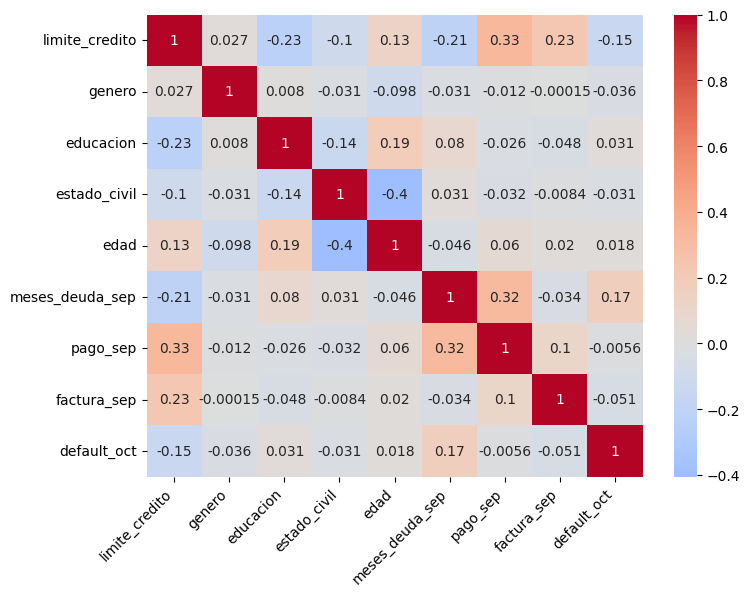

In [20]:
matriz_corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", center=0)
plt.xticks(rotation=45, ha="right")
plt.show()

El gráfico muestra los **coeficientes de correlación de Pearson** entre atributos. Elegimos `meses_deuda_sep` porque es el atributo con **correlación positiva** más alta con el *target*: mayores atrasos en septiembre se asocian con mayor probabilidad de incumplir en octubre. También elegimos `limite_credito`, que presenta una **correlación negativa** apreciable con `default_oct` (*target*): límites más bajos se observan con mayor frecuencia en clientes que caen en default. Ambos combinan poder predictivo (por su correlación con el **target**) y plausibilidad desde el comportamiento financiero reciente.

Como se puede ver en siguiente boxplot, los clientes que cayeron en **default** presentan un límite de crédito con mediana e IQR más bajos que los que no cayeron en **default**. Esto respalda la **correlación negativa** observada: límites menores se asocian con mayor probabilidad de incumplimiento. Si bien las distribuciones se superponen (no es determinístico), la diferencia de niveles sugiere que el límite de crédito aporta poder predictivo complementario al atraso reciente.

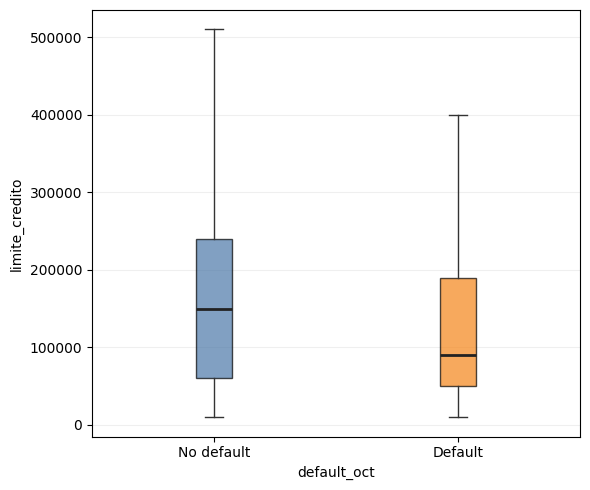

In [21]:
TARGET = "default_oct"
VAR = "limite_credito"

g0 = df.loc[df[TARGET] == 0, VAR].dropna()
g1 = df.loc[df[TARGET] == 1, VAR].dropna()

labels = ["No default", "Default"]
colors = ["#4C78A8", "#F58518"]

plt.figure(figsize=(6,5))
bp = plt.boxplot([g0, g1],
                 tick_labels=labels,
                 showfliers=False,
                 patch_artist=True)

# Colorear cada box
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(c)
    patch.set_alpha(0.7)
# Ajustes de líneas/medianas
for median in bp['medians']:
    median.set_color("#222")
    median.set_linewidth(2)
for whisker in bp['whiskers']:
    whisker.set_color("#333")
for cap in bp['caps']:
    cap.set_color("#333")

plt.ylabel(VAR)
plt.xlabel(TARGET)

plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()
